In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib
import datetime
import cv2
import matplotlib.pyplot as plt


# printout versions
print(f"Tensor Flow Version: {tf.__version__}")
print(f"numpy Version: {np.version.version}")

Tensor Flow Version: 2.5.0
numpy Version: 1.19.5


In [ ]:
data_dir = pathlib.Path("/content/drive/My Drive/ML_Project/Train")
image_count = len(list(data_dir.glob('*/*.JPG')))
print(image_count)
# classnames in the dataset specified
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" ])
print(CLASS_NAMES)
# print length of class names
output_class_units = len(CLASS_NAMES)
print(output_class_units)

2473
['Pepper_Unhealthy' 'Pepper_Healthy']
2


In [ ]:
model = tf.keras.models.Sequential([
    # 1st conv
  tf.keras.layers.Conv2D(96, (11,11),strides=(4,4), activation='relu', input_shape=(227, 227, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
    # 2nd conv
  tf.keras.layers.Conv2D(256, (11,11),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
     # 3rd conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 4th conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 5th Conv
  tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2, 2)),
  # To Flatten layer
  tf.keras.layers.Flatten(),
  # To FC layer 1
  tf.keras.layers.Dense(4096, activation='relu'),
    # add dropout 0.5 ==> tf.keras.layers.Dropout(0.5),
  #To FC layer 2
  tf.keras.layers.Dense(4096, activation='relu'),
    # add dropout 0.5 ==> tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(output_class_units, activation='softmax')
])




In [ ]:
BATCH_SIZE = 32             # Can be of size 2^n, but not restricted to. for the better utilization of memory
IMG_HEIGHT = 227            # input Shape required by the model
IMG_WIDTH = 227             # input Shape required by the model
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

# Rescalingthe pixel values from 0~255 to 0~1 For RGB Channels of the image.
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# training_data for model training
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), #Resizing the raw dataset
                                                     classes = list(CLASS_NAMES))

Found 2475 images belonging to 2 classes.


In [ ]:
model.compile(optimizer='sgd', loss="categorical_crossentropy", metrics=['accuracy'])

# Summarizing the model architecture and printing it out
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 27, 256)       2973952   
_________________________________________________________________
batch_normalization_6 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 384)       885120    
_________________________________________________________________
batch_normalization_7 (Batch (None, 27, 27, 384)      

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get("accuracy")==1.00 and logs.get("loss")<0.03):
            print("\nReached 100% accuracy so stopping training")
            self.model.stop_training =True
callbacks = myCallback()

# TensorBoard.dev Visuals
log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=50,
      callbacks=[tensorboard_callback,callbacks])

# Saving the model
model.save('/content/drive/My Drive/ML_Project/Models/{NAME}.model')

Epoch 1/50
78/78 [==============================] - 1240s 16s/step - loss: 0.9238 - accuracy: 0.8400
Epoch 2/50
78/78 [==============================] - 1244s 16s/step - loss: 0.1084 - accuracy: 0.9608
Epoch 3/50
78/78 [==============================] - 1240s 16s/step - loss: 0.0388 - accuracy: 0.9899
Epoch 4/50
78/78 [==============================] - 1239s 16s/step - loss: 0.0221 - accuracy: 0.9956
Epoch 5/50
78/78 [==============================] - 1239s 16s/step - loss: 0.0151 - accuracy: 0.9964
Epoch 6/50
78/78 [==============================] - 1239s 16s/step - loss: 0.0051 - accuracy: 1.0000

Reached 100% accuracy so stopping training
INFO:tensorflow:Assets written to: /content/drive/My Drive/ML_Project/Models/{NAME}.model/assets


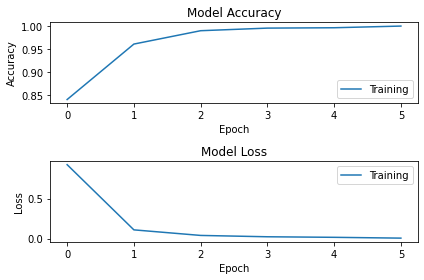

In [ ]:
plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()

plt.show()

In [ ]:
# def prepare(filepath):
#     img_size = 100
#     img = cv2.imread(filepath) 
#     img_resize = cv2.resize(img, (img_size, img_size))  
#     return img_resize

In [ ]:
# prediction = model.predict("/content/drive/My Drive/ML_Project/Test/Pepper_Healthy/Healthy1.JPG")
# print((prediction))

# CATEGORIES = ["healthy", "unhealthy"]

# pred_class = CATEGORIES[np.argmax(prediction)]
# print(pred_class)

In [ ]:
import tensorflow as tf
import numpy as np
import pathlib
import datetime
# Raw Dataset Directory
data_dir = pathlib.Path("/content/drive/My Drive/ML_Project/Test")
image_count = len(list(data_dir.glob('*/*.JPG')))
# print total no of images for all classes
print(image_count)
# classnames in the dataset specified
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" ])
# print list of all classes
print(CLASS_NAMES)
# print length of class names
output_class_units = len(CLASS_NAMES)
print(output_class_units)
#preprocess the data
BATCH_SIZE = 1             # Can be of size 2^n, but not restricted to. for the better utilization of memory
IMG_HEIGHT = 227            # input Shape required by the model
IMG_WIDTH = 227             # input Shape required by the model

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), #Resizing the raw dataset
                                                     classes = list(CLASS_NAMES))
#Loading the saved model
new_model = tf.keras.models.load_model("/content/drive/My Drive/ML_Project/Models/{NAME}.model")
new_model.summary()
loss, acc = new_model.evaluate(test_data_gen)
print("accuracy:{:.2f}%".format(acc*100))

19
['Pepper_Unhealthy' 'Pepper_Healthy']
2
Found 20 images belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 27, 256)       2973952   
_________________________________________________________________
batch_normalization_6 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 384)       885120    
_____________________________________